# Long-Running Notebook Tasks

Assume that you're working on a notebook that contains
1. a long-running computation
2. a visualization.

You run the long computation, get the results, and plot the visualization.
You realize that your parameters weren't quite right, so you want to run the long computation again.
But you also want to tweak some aspects of the visualization while it's running.

Since a notebook can only execute one cell at a time, once you start the long-running computation, you won't be able to re-run the visualization cells to see your updates.

In this notebook, I'll demonstrate one way to address this issue using multi-threading and futures (a.k.a. promises).

## Imports

In [1]:
import concurrent.futures as cf
from datetime import datetime
from collections import OrderedDict
import time

import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [2]:
# Create a thread pool to manage the execution of background tasks
pool = cf.ThreadPoolExecutor()
# Create a dictionary to store the results, keyed by timestamp.
# I'm using an OrderedDict just to make it easier to fetch the last result automatically.
futures_dict = OrderedDict()

## Function definitions

This is the actual computation. It will take a long time for this function to return.

In [3]:
def long_computation(x, noise_magnitude):
    noise = noise_magnitude * np.random.rand(len(x))
    y = np.sin(x) + noise
    # Pretend this takes a long time
    time.sleep(10)
    return y

This is a wrapper that 
1. launches the actual computation in a background thread
2. gets the current time
3. stores a future corresponding to the computation in the global dictionary.

This function returns immediately after it's called with a future that can be used
to check the state of the computation (with fut.done()) and get the result when it's finished (with fut.result()).

In [4]:
def run_computation(x, noise_magnitude):
    # Immediately get a future to return. Don't have to wait for the long computation to finish.
    future = pool.submit(long_computation, x, noise_magnitude)
    # Use the current timestamp as the dictionary key
    key = datetime.now().isoformat()
    # Save this for later
    futures_dict[key] = future

This is just a utility function to get the last element that matches some criteria.

In our case, we'll use it to automatically get the latest completed result of the long-running computation.

In [5]:
def find_last(criteria, iterator):
    return next(filter(criteria, reversed(iterator)))

## Example Usage Instructions

1. Run the computation.
2. Wait for it to finish.
3. Change `noise_magnitude` and run the computation again.
4. Change the visualization (e.g. `color='blue'`) and re-display it with the results of the computation from step 1 while the computation from step 3 is still running.
5. Once the computation from step 3 is finished, re-run the visualization cell, which should now show the results of the computation from step 3.

### Run the computation

In [6]:
x = np.linspace(0, 5, 501)

This cell will launch the computation in the background
and return immediately without blocking the notebook

In [7]:
noise_magnitude = 0.5
run_computation(x, noise_magnitude)

### View the runs
Re-run this cell to see the status of all the computations you've launched

In [11]:
futures_dict

OrderedDict([('2021-03-25T01:05:50.588361',
              <Future at 0x7f047db768d0 state=finished returned ndarray>),
             ('2021-03-25T01:06:08.569962',
              <Future at 0x7f047e64ddd0 state=running>)])

### Visualization
Since the long-running computation doesn't block other cells from be executing,
this cell can be edited and re-run while you're waiting for the new version of the computation to finish. 

It will always use the most recent results available. If no results are available yet, it will produce a `StopIteration` exception.

Text(0.5,1,'2021-03-25T01:05:50.588361')

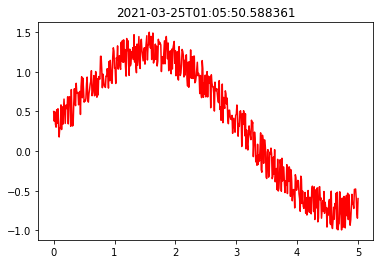

In [12]:
# Get the most recent result
latest_key, latest_fut = find_last(lambda pair: pair[1].done(), futures_dict.items())
latest_result = latest_fut.result()

# Plot it
plt.plot(x, latest_result, color='red')
plt.title(latest_key)